In [1]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.8/680.8 kB 9.4 MB/s eta 0:00:00


In [2]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


# DATA_DIR = tf.keras.utils.get_file(
#     "modelnet.zip",
#     "http://modelnet.cs.princeton.edu/ModelNet40.zip",
#     extract=True,
# )
# DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")

473402300/473402300 [==============================] - 36s 0us/step


In [4]:
DATA_DIR

'/root/.keras/datasets/ModelNet10'

In [5]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

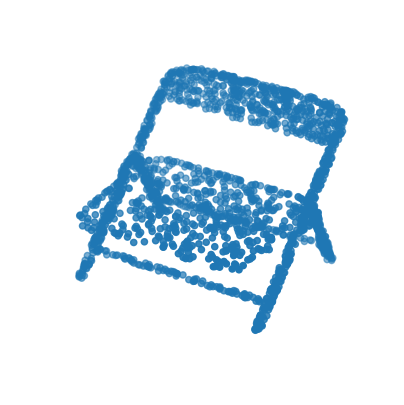

In [7]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [8]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [9]:
NUM_POINTS = 2048
NUM_CLASSES = 40
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: chair
processing class: night_stand
processing class: bathtub
processing class: toilet
processing class: bed
processing class: dresser
processing class: sofa
processing class: desk
processing class: monitor
processing class: table


In [10]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [11]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [12]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'l2': float(self.l2reg)}

In [13]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [25]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 2048, 32)     128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 2048, 32)    128         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 2048, 32)     0           ['batch_normalization_34[0

In [26]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
125/125 [==============================] - 23s 57ms/step - loss: 3.9345 - sparse_categorical_accuracy: 0.2829 - val_loss: 55282028.0000 - val_sparse_categorical_accuracy: 0.1938
Epoch 2/100
125/125 [==============================] - 6s 51ms/step - loss: 3.0076 - sparse_categorical_accuracy: 0.4017 - val_loss: 2408807325352591360.0000 - val_sparse_categorical_accuracy: 0.3855
Epoch 3/100
125/125 [==============================] - 6s 51ms/step - loss: 2.7334 - sparse_categorical_accuracy: 0.4811 - val_loss: 20910835393462534144.0000 - val_sparse_categorical_accuracy: 0.3469
Epoch 4/100
125/125 [==============================] - 6s 51ms/step - loss: 2.5615 - sparse_categorical_accuracy: 0.5492 - val_loss: 91.0221 - val_sparse_categorical_accuracy: 0.3756
Epoch 5/100
125/125 [==============================] - 6s 51ms/step - loss: 2.5174 - sparse_categorical_accuracy: 0.5660 - val_loss: 399684536964743168.0000 - val_sparse_categorical_accuracy: 0.4703
Epoch 6/100
125/125 [======

In [27]:
model.save_weights('Pointnet_model.h5')


In [28]:
from keras import models    
loaded_model = models.load_weights('my_model.h5')

AttributeError: ignored

1/1 [==============================] - 1s 616ms/step


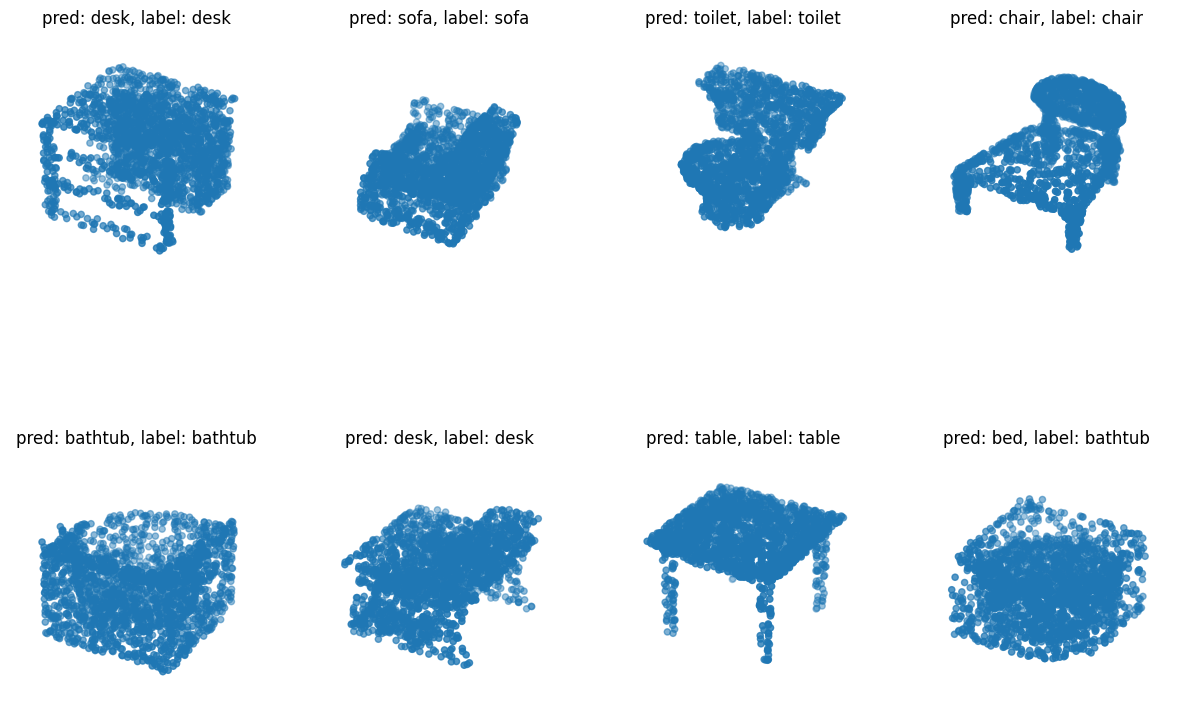

In [29]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# get all test data
test_data = test_dataset.as_numpy_iterator()
test_points = []
test_labels = []
for points, labels in test_data:
    test_points.append(points)
    test_labels.append(labels)
test_points = np.concatenate(test_points, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# run test data through model
preds = model.predict(test_points)
preds = tf.math.argmax(preds, -1)

# calculate metrics
accuracy = np.mean(preds == test_labels)
confusion_mat = confusion_matrix(test_labels, preds)
class_report = classification_report(test_labels, preds, target_names=CLASS_MAP.values())

# print metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_mat)
print("Classification Report:")
print(class_report)


29/29 [==============================] - 1s 9ms/step
Accuracy: 0.8843612334801763
Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0]
 [  0  68   0   1   0  12   1   0   3   1]
 [  1   0  33   3   7   0   4   0   0   2]
 [  2   0   0  97   0   0   0   0   1   0]
 [  4   0   0   0  93   0   2   0   0   1]
 [  0   4   0   2   0  69   0   1  10   0]
 [  2   0   0   0   0   0  96   2   0   0]
 [  0   2   0   0   1   1   7  66   3   6]
 [  1   1   0   0   0   0   0   0  98   0]
 [  1   1   0   0   0   0   0  14   1  83]]
Classification Report:
              precision    recall  f1-score   support

       chair       0.90      1.00      0.95       100
 night_stand       0.89      0.79      0.84        86
     bathtub       1.00      0.66      0.80        50
      toilet       0.94      0.97      0.96       100
         bed       0.92      0.93      0.93       100
     dresser       0.84      0.80      0.82        86
        sofa       0.87      0.96      0.91       100
        desk 